# Distribution-abundance Train and Test Random Forest AIM

**Written by Timm Nawrocki**

*Last updated Saturday, October 6, 2018.*

In [1]:
# -*- coding: utf-8 -*-
# ---------------------------------------------------------------------------
# Distribution-abundance Train and Test
# Author: Timm Nawrocki, Alaska Center for Conservation Science
# Created on: 2018-10-05
# Usage: Must be executed as a Jupyter Notebook in an Anaconda 3 installation on a Google Cloud virtual machine with 64 vCPUs and 57.6 GB of CPU memory with an Ubuntu operating system (18.04 LTS).
# Description: "Distribution-Abundance Train and Test" trains a multi-class classification model to determine species presence and absence and estimate species abundance. The probabilistic results are combined into a single continuous output that can theoretically range from 0 to 100 representing percent cover. All model performance metrics are calculated on independent test partitions.
# ---------------------------------------------------------------------------

## 1. Introduction

This script runs the model train and test steps to output a model performance and variable importance report, trained classifier file, trained regressor file, and threshold files that can be transferred to the predict script. The script is formatted as a Jupyter Notebook and is intended to be run on a Google Cloud virtual machine with 64 vCPUs and 57.6 GB of CPU memory with an Ubuntu operating system (18.04 LTS). The classifier and regressor in this script are set to use 16 cores and may work inefficiently or not at all on a machine that has less than 64 cores. For information on generating inputs for this script or on setting up Google Cloud virtual machines, see the [project readme](https://github.com/accs-uaa/vegetation-cover-modeling).

The distribution and abundance of a species is two distinct problems: 1. Where does the species occur? 2. Where the species occurs, how much is present? To represent the nested nature of the problems, we developed a hierarchical model where a classifier predicted species presence-absence and a regressor predicted species abundance in areas of predicted species presence. The practical advantage to this hierarchical method is that it accurately predicts zeros (i.e., absences), which are of disproportionate ecological value than exact prediction of other values along the gradient.

## 2. Import Data and Variables

This script relies on data that has been pre-processed into a csv file using the ArcGIS Pro python tools available in the repository. The csv file must include all presence and absence observations for the target taxon or aggregate and all values for predictors extracted to the site locations. Variables defined below must be modified to match the input csv file if changes to the construction of features are made.

In [117]:
# Define input file
input_file = 'E:/VegetationEcology/Data_Harmonization/Project_GIS/Data_Output/speciesData/salix_pulchra.csv'
# Define output folder
output_folder = 'E:/VegetationEcology/Data_Harmonization/Project_GIS/Data_Output/modelResults/salix_pulchra_rf_aim_predictorsubset/'
# Define output report
output_report_name = 'salix-pulchra-report.html'
# Define species, genera, or aggregate name
taxon_name = 'Salix pulchra'

In [118]:
# Define variable sets
predictor_all = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'may_1_ultraBlue', 'may_2_blue', 'may_3_green', 'may_4_red', 'may_5_nearInfrared', 'may_6_shortInfrared1', 'may_7_shortInfrared2', 'may_evi2', 'may_nbr', 'may_ndmi', 'may_ndsi', 'may_ndvi', 'may_ndwi', 'june_1_ultraBlue', 'june_2_blue', 'june_3_green', 'june_4_red', 'june_5_nearInfrared', 'june_6_shortInfrared1', 'june_7_shortInfrared2', 'june_evi2', 'june_nbr', 'june_ndmi', 'june_ndsi', 'june_ndvi', 'june_ndwi', 'july_1_ultraBlue', 'july_2_blue', 'july_3_green', 'july_4_red', 'july_5_nearInfrared', 'july_6_shortInfrared1', 'july_7_shortInfrared2', 'july_evi2', 'july_nbr', 'july_ndmi', 'july_ndsi', 'july_ndvi', 'july_ndwi', 'august_1_ultraBlue', 'august_2_blue', 'august_3_green', 'august_4_red', 'august_5_nearInfrared', 'august_6_shortInfrared1', 'august_7_shortInfrared2', 'august_evi2', 'august_nbr', 'august_ndmi', 'august_ndsi', 'august_ndvi', 'august_ndwi', 'september_1_ultraBlue', 'september_2_blue', 'september_3_green', 'september_4_red', 'september_5_nearInfrared', 'september_6_shortInfrared1', 'september_7_shortInfrared2', 'september_evi2', 'september_nbr', 'september_ndmi', 'september_ndsi', 'september_ndvi', 'september_ndwi']
zero_variable = ['zero']
strata = ['strata']
cover = ['cover']
retain_variables = ['project', 'siteID', 'siteCode', 'methodSurvey', 'methodCover']
coordinates = ['POINT_X', 'POINT_Y']
all_variables = retain_variables + coordinates + predictor_all + zero_variable + strata + cover
absence = ['absence']
presence = ['presence']
response = ['response']
prediction = ['prediction']
output_variables = all_variables + absence + presence + response + prediction

## 3. Initialize

This script has general dependencies on the *os* package for file system manipulations, the *numpy* and *pandas* packages for data manipulations, and the *seaborn* and *matplotlib* packages for plotting. *GPy* and *GPyOpt* are Gaussian Process packages that drive the bayesian optimization of hyperparameters. *XGBoost* provides the gradient boosting classifier and regressor used to create the composite predictions. *Scikit Learn* provides a random forest classifier and regressor for comparison to the gradient boosting performance, model selection and cross validation tools, performance metrics, and a function to save models.

In [119]:
# Import packages for file manipulation, data manipulation, and plotting
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
# Import module for altering output display
from IPython.display import clear_output
# Import packages for bayesian optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
# Import XGBoost gradient boosting implementations
from xgboost import XGBClassifier
from xgboost import XGBRegressor
# Import modules for model selection, cross validation, random forest, and performance from Scikit Learn
from sklearn.utils import shuffle
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.externals import joblib

In [120]:
# Create a plots folder if it does not exist
plots_folder = os.path.join(output_folder, "plots")
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

In [121]:
# Define output test data
output_csv = os.path.join(output_folder, 'prediction.csv')
# Define output model files
output_classifier = os.path.join(output_folder, 'classifier.joblib')
output_regressor = os.path.join(output_folder, 'regressor.joblib')
# Define output threshold file
threshold_file = os.path.join(output_folder, 'threshold.txt')
# Define threshold and metrics table
metrics_file = os.path.join(output_folder, 'metrics.csv')
# Define output correlation plot
variable_correlation = os.path.join(plots_folder, "variable_correlation.png")
# Define output variable importance plots
importance_classifier = os.path.join(plots_folder, "importance_classifier.png")
importance_regressor = os.path.join(plots_folder, "importance_regressor.png")
# Define output bayesian optimization convergence plots
convergence_classifier = os.path.join(plots_folder, "convergence_classifier.png")
convergence_regressor = os.path.join(plots_folder, "convergence_regressor.png")

In [122]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 24
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

## 4. Functions

Analyses are conducted in units represented by functions. The functions are defined below in order of use. In general, functions in this script fall into three categories: Bayesian Optimization, Train and Test Iteration, and Export Results.

### 4.1. Bayesian Optimization Functions

In [123]:
# Define an optimization objective function for the xgboost classifier
def cvClassifier(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBClassifier(max_depth=int(parameters[0]),
                     learning_rate=parameters[1],
                     n_estimators=int(parameters[2]),
                     silent=True,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=1,
                     gamma=parameters[3],
                     min_child_weight=int(parameters[4]),
                     max_delta_step=int(parameters[5]),
                     subsample=parameters[6],
                     colsample_bytree=parameters[7],
                     colsample_bylevel=parameters[8],
                     reg_alpha=parameters[9],
                     reg_lambda=parameters[10],
                     scale_pos_weight=parameters[11]),
        X, y, scoring='roc_auc', cv=5).mean()
    inverse_score = np.array((1-score)*-1)
    return inverse_score

In [124]:
# Define an optimization objective function for the xgboost regressor
def cvRegressor(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBRegressor(max_depth=int(parameters[0]),
                     learning_rate=parameters[1],
                     n_estimators=int(parameters[2]),
                     silent=True,
                     objective='reg:linear',
                     booster='gbtree',
                     n_jobs=1,
                     gamma=parameters[3],
                     min_child_weight=int(parameters[4]),
                     max_delta_step=int(parameters[5]),
                     subsample=parameters[6],
                     colsample_bytree=parameters[7],
                     colsample_bylevel=parameters[8],
                     reg_alpha=parameters[9],
                     reg_lambda=parameters[10],
                     scale_pos_weight=parameters[11]),
        X, y, scoring='neg_mean_squared_error', cv=5).mean()
    score = np.array(score)
    return score

In [125]:
# Define an optimization function
def bayesianOptimizer(objective_function, X, y, plot_file):
    # Create the hyperparameter search domain
    domain=[{'name': 'max_depth', 'type': 'discrete', 'domain': (5, 100)},
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (50, 5000)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (0, 10)},
            {'name': 'max_delta_step', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1)},
            {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.3, 1.0)},
            {'name': 'colsample_bylevel', 'type': 'continuous', 'domain': (0.3, 1.0)},
            {'name': 'reg_alpha', 'type': 'continuous', 'domain': (1, 10)},
            {'name': 'reg_lamda', 'type': 'continuous', 'domain': (1, 10)},
            {'name': 'scale_pos_weight', 'type': 'continuous', 'domain': (1, 5)}]
    # Initialize the Bayesian Optimizer
    optimizer = BayesianOptimization(f=objective_function,
                                     domain=domain,
                                     model_type='GP',
                                     initial_design_numdata=25,
                                     initial_design_type='random',
                                     acquisition_type ='EI',
                                     exact_feval=False,
                                     maximize=True)
    # Run 1000 iterations of optimization
    optimizer.run_optimization(max_iter=250)
    # Plot the convergence of the best solution
    optimizer.plot_convergence(filename=plot_file)
    # Return results
    return optimizer

### 4.2. Train and Test Iteration Functions

In [126]:
# Create a function to create the train and test partitions
def partitionData(inData, all_variables, predictors, response, strata):
    # Create train and test splits
    X = inData[all_variables]
    y = inData[response[0]]
    stratify = inData[strata[0]]
    all_train, all_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size = 0.38,
                                                            train_size = 0.62,
                                                            random_state = None,
                                                            shuffle = True,
                                                            stratify = stratify)
    # Reset the index on the train and test splits
    all_train = all_train.reset_index()
    all_test = all_test.reset_index()
    return all_train, all_test

In [127]:
# Create a function to train a classifier on the train X and y and predict the test X
def trainPredictClassifier(train, test, predictors, response):
    # Define X and y
    X_train = train[predictors]
    y_train = train[response[0]]
    X_test = test[predictors]
    # Fit a classifier to the train X and y
    classifier = RandomForestClassifier(n_estimators = 500,
                                        criterion = 'entropy',
                                        max_features = 'log2',
                                        bootstrap = True,
                                        oob_score = False,
                                        n_jobs = 1,
                                        class_weight = 'balanced')
    classifier.fit(X_train, y_train)
    # Use the classifier to predict class probabilities
    prediction = classifier.predict_proba(X_test)
    # Concatenate predicted values to test data frame
    test = pd.concat([test, pd.DataFrame(prediction)], axis=1)
    test = test.rename(index=int, columns={0: 'absence', 1: 'presence'})
    # Return the predictions
    return test, classifier

In [128]:
# Create a function to train a regressor on the train X and y and predict the test X
def trainPredictRegressor(train, test, predictors, response):
    # Define X and y
    X_train = train[predictors]
    y_train = train[response[0]]
    X_test = test[predictors]
    # Fit a regressor to the train X and y
    regressor = RandomForestRegressor(n_estimators=500,
                                      criterion='mse',
                                      bootstrap=True,
                                      oob_score=False,
                                      n_jobs=1)
    regressor.fit(X_train, y_train)
    # Use the regressor to predict response values
    prediction = regressor.predict(X_test)
    # Concatenate predicted values to test data frame
    test = pd.concat([test, pd.DataFrame(prediction)], axis=1)
    test = test.rename(index=int, columns={0: 'response'})
    # Return the predictions
    return test, regressor

In [129]:
# Define a function to calculate performance metrics based on a specified threshold value
def testPresenceThreshold(predict_probability, threshold, y_test):
    # Create an empty array of zeroes that matches the length of the probability predictions
    predict_thresholded = np.zeros(predict_probability.shape)
    # Set values for all probabilities greater than or equal to the threshold equal to 1
    predict_thresholded[predict_probability >= threshold] = 1
    # Determine error rates
    confusion_test = confusion_matrix(y_test, predict_thresholded)
    true_negative = confusion_test[0,0]
    false_negative = confusion_test[1,0]
    true_positive = confusion_test[1,1]
    false_positive = confusion_test[0,1]
    # Calculate sensitivity and specificity
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    # Calculate AUC score
    auc = roc_auc_score(y_test, predict_probability)
    # Calculate overall accuracy
    accuracy = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
    # Return the thresholded probabilities and the performance metrics
    return (sensitivity, specificity, auc, accuracy)

In [130]:
# Create a function to determine a presence threshold
def determineOptimalThreshold(predict_probability, y_test):
    # Iterate through numbers between 0 and 1000 to output a list of sensitivity and specificity values per threshold number
    i = 1
    sensitivity_list = []
    specificity_list = []
    while i < 1001:
        threshold = i/1000
        sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        i = i + 1
    # Calculate a list of absolute value difference between sensitivity and specificity and find the optimal threshold
    difference_list = [np.absolute(a - b) for a, b in zip(sensitivity_list, specificity_list)]
    value, threshold = min((value, threshold) for (threshold, value) in enumerate(difference_list))
    threshold = threshold/1000
    # Calculate the performance of the optimal threshold
    sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
    # Return the optimal threshold and the performance metrics of the optimal threshold
    return threshold, sensitivity, specificity, auc, accuracy

In [131]:
# Create a function to composite model results
def compositePrediction(test, presence, response, threshold):
    # Define a function to threshold absences and set presences equal to regression response
    def compositeRows(row):
        if row[presence[0]] < threshold:
            return 0
        elif row[presence[0]] >= threshold:
            return row[response[0]]
    # Apply function to all rows in test data
    test['prediction'] = test.apply(lambda row: compositeRows(row), axis=1)
    # Return the test data frame with composited results
    return test

In [132]:
# Create a function to calculate pseudo r-squared and RMSE for the composited prediction
def calculatePerformance(test, cover, prediction):
    # Define the true values and the predicted values for the response variable
    y_test = test[cover[0]]
    y_prediction = test[prediction[0]]
    # Calculate pseudo r-squared
    r_score = r2_score(y_test, y_prediction, sample_weight=None, multioutput='uniform_average')
    # Calculate error
    mae = mean_absolute_error(y_test, y_prediction)
    rmse = np.sqrt(mean_squared_error(y_test, y_prediction))
    # Return performance metrics
    return r_score, mae, rmse

### 4.3 Export Results Functions

In [133]:
# Define a function to plot Pearson correlation of predictor variables
def plotVariableCorrelation(X_train, outFile):
    # Calculate Pearson correlation coefficient between the predictor variables, where -1 is perfect negative correlation and 1 is perfect positive correlation
    correlation = X_train.astype('float64').corr()
    # Generate a mask for the upper triangle of plot
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plot.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    correlation_plot = sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})
    correlation_figure = correlation_plot.get_figure()
    correlation_figure.savefig(outFile, bbox_inches='tight', dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [134]:
# Define a function to plot variable importances
def plotVariableImportances(inModel, X_train, outVariableFile):
    # Get numerical feature importances
    importances = list(inModel.feature_importances_)
    # List of tuples with variable and importance
    feature_list = list(X_train.columns)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Initialize the plot and set figure size
    variable_figure = plot.figure()
    plot.style.use('fivethirtyeight')
    fig_size = plot.rcParams["figure.figsize"]
    fig_size[0] = 36
    fig_size[1] = 12
    plot.rcParams["figure.figsize"] = fig_size
    # Create list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart of the variable importances
    plot.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plot.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plot.ylabel('Importance'); plot.xlabel('Variable'); plot.title('Variable Importances');
    # Export
    variable_figure.savefig(outVariableFile, bbox_inches="tight", dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [135]:
# Create a function to train and export a classifier
def trainExportClassifier(input_data, predictors, response, outModel, outImportance):
    # Define the predictor labels (X) and the response label (y) in the input dataframe
    X = input_data[predictors]
    y = input_data[response[0]]
    # Fit a classifier to the input dataset
    classifier = RandomForestClassifier(n_estimators = 500,
                                        criterion = 'entropy',
                                        max_features = 'log2',
                                        bootstrap = True,
                                        oob_score = False,
                                        n_jobs = 1,
                                        class_weight = 'balanced')
    classifier.fit(X, y)
    # Save classifier to an external file
    joblib.dump(classifier, outModel)
    # Export a variable importance plot
    plotVariableImportances(classifier, X, outImportance)

In [136]:
def trainExportRegressor(input_data, predictors, response, outModel, outImportance):
    # Define the predictor labels (X) and the response label (y) in the input dataframe
    X = input_data[predictors]
    y = input_data[response[0]]
    # Fit a classifier to the input dataset
    regressor = RandomForestRegressor(n_estimators=500,
                                      criterion='mse',
                                      bootstrap=True,
                                      oob_score=False,
                                      n_jobs=1)
    regressor.fit(X, y)
    # Save classifier to an external file
    joblib.dump(regressor, outModel)
    # Export a variable importance plot
    plotVariableImportances(regressor, X, outImportance)

## 5. Conduct Analyses

The analyses are subdivided into subsections: load data, bayesian optimization, train and test iterations, and export results. The majority of analytical time is devoted to conducting bayesian optimization iterations and train and test iterations. The XGBoost implementation of gradient boosting is the primary algorithm. Random forest is included as a baseline to exceed with tuned gradient boosting.

We use a Bayesian statistical framework with Gaussian Process as the generative model to find an optimal set of hyperparameters for the classifier and regressor. The Bayesian Optimization tunes species-specific models that make the best generalizations as estimated by 5-fold cross validation. The domain space for bayesian optimization is large, so we initially sample 50 points at random and then conduct 1000 optimization iterations to converge on a best set of hyperparameters. Optimization occurs independently for the classifier and the regressor. The performance of each optimization run is determined using 5-fold cross validation.

The optimal hyperparameters are passed into 100 iterations of training and testing in which the results of the classifier and regressor are composited to determine overall performance. For each iteration, we withhold 20% of the data at random stratified by broad cover ranges as an independent test partition. The composited prediction results are appended into a single data frame for additional analyses and plotting external to this script.

Outputs of the analysis are:
1. Report of performance, including the following plots:
  1. Convergence of the classifier hyperparameters
  2. Convergence of the regressor hyperparameters
  3. Variable importances of the classifier
  4. Variable importances of the regressor
  5. Pearson correlation for all predictors
2. Model files:
  1. Classifier
  2. Regressor
3. Table of performance metrics
4. Mean threshold
5. Test predictions from 100 validation iterations

### 5.1. Load Data

In [137]:
# Create data frame of input data
input_data = pd.read_csv(input_file)
# Convert values to floats
input_data[predictor_all + cover + coordinates] = input_data[predictor_all + cover + coordinates].astype(float)
# Convert values to integers
input_data[strata + zero_variable] = input_data[strata + zero_variable].astype(int)
# Shuffle data
input_data = shuffle(input_data)

In [138]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 36
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

## 5.2 Feature Selection

The number of available features is very large and includes variables that are likely uninformative or minimally informative to the species. Species-specific feature selection identifies the optimal number of features for the species data using a shuffle cross validation method. Variable importances for the full feature set are created by averaging the results of 100 independent model runs. The final feature set for the classifier and the regressor is derived of the most important features equal to the optimal number threshold.

In [139]:
# Define a cross validation split method
cv_splits = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.7, random_state=None)

In [140]:
# Define the X and y data
X = input_data[predictor_all]
y = input_data[zero_variable]

In [141]:
# Define the classifier used to generate variable importances
classifier = RandomForestClassifier(n_estimators = 500,
                                    criterion = 'entropy',
                                    max_features = 'log2',
                                    bootstrap = True,
                                    oob_score = False,
                                    n_jobs = 1,
                                    class_weight = 'balanced')

In [142]:
# Define a recursive feature eliminator for the classifier using shuffled cross validation
recursive_eliminator_classifier = RFECV(estimator=classifier, step=1, cv=cv_splits, scoring='roc_auc')

In [143]:
# Fit the recursive feature eliminator
recursive_eliminator_classifier.fit(X, y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=0.7),
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
   n_jobs=1, scoring='roc_auc', step=1, verbose=0)

In [144]:
# Print optimal number of features for the classifier
print("Optimal number of features : %d" % recursive_eliminator_classifier.n_features_)

Optimal number of features : 80


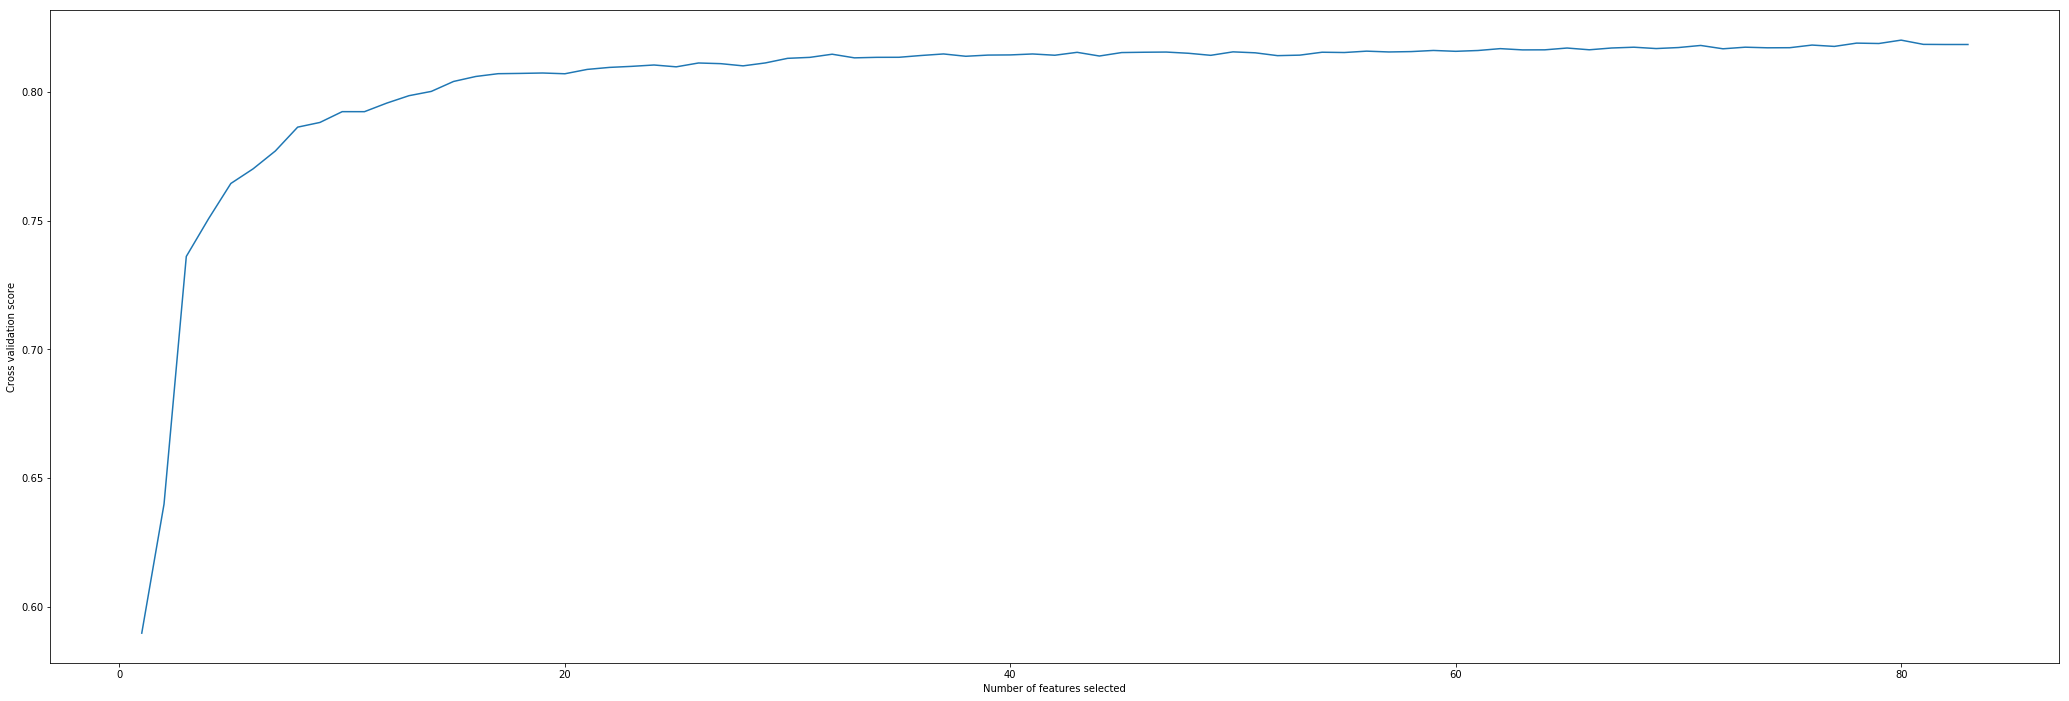

In [145]:
# Plot the results of the recursive feature eliminator
plot.figure()
plot.xlabel("Number of features selected")
plot.ylabel("Cross validation score")
plot.plot(range(1, len(recursive_eliminator_classifier.grid_scores_) + 1), recursive_eliminator_classifier.grid_scores_)
plot.show()

In [146]:
# Select the optimal subset of features for the classifier
classifier_features = pd.DataFrame({'predictor': list(X.columns),
                                    'select': recursive_eliminator_classifier.ranking_.tolist()})
classifier_features = classifier_features.loc[classifier_features['select'] == 1]
classifier_features = classifier_features['predictor'].tolist()
classifier_features

['compoundTopographic',
 'dateFreeze_2000s',
 'dateThaw_2000s',
 'elevation',
 'floodplainsDist',
 'growingSeason_2000s',
 'heatLoad',
 'precipAnnual_2000s',
 'roughness',
 'siteExposure',
 'slope',
 'streamLargeDist',
 'streamSmallDist',
 'summerWarmth_2000s',
 'surfaceRelief',
 'aspect',
 'may_1_ultraBlue',
 'may_2_blue',
 'may_3_green',
 'may_4_red',
 'may_5_nearInfrared',
 'may_6_shortInfrared1',
 'may_7_shortInfrared2',
 'may_evi2',
 'may_nbr',
 'may_ndmi',
 'may_ndsi',
 'may_ndvi',
 'may_ndwi',
 'june_1_ultraBlue',
 'june_2_blue',
 'june_3_green',
 'june_4_red',
 'june_5_nearInfrared',
 'june_6_shortInfrared1',
 'june_7_shortInfrared2',
 'june_evi2',
 'june_nbr',
 'june_ndmi',
 'june_ndsi',
 'june_ndvi',
 'june_ndwi',
 'july_1_ultraBlue',
 'july_2_blue',
 'july_3_green',
 'july_4_red',
 'july_5_nearInfrared',
 'july_6_shortInfrared1',
 'july_7_shortInfrared2',
 'july_evi2',
 'july_nbr',
 'july_ndmi',
 'july_ndsi',
 'july_ndvi',
 'july_ndwi',
 'august_1_ultraBlue',
 'august_2_blue

Something something the regressor.

In [147]:
# Subset the training data to quantitative presences
presence_data = input_data[input_data[cover[0]] >= 1]
presence_data = presence_data[presence_data['methodCover'] == 'Quantitative']
presence_data = presence_data[presence_data['project'] == 'AIM NPR-A']

In [148]:
# Define the X and y data
X = presence_data[predictor_all]
y = presence_data[cover]

In [149]:
# Define the regressor used to generate variable importances
regressor = RandomForestRegressor(n_estimators=500,
                                  criterion='mse',
                                  bootstrap=True,
                                  oob_score=False,
                                  n_jobs=1)

In [150]:
# Define a recursive feature eliminator for the regressor using shuffled cross-validation
recursive_eliminator_regressor = RFECV(estimator=regressor, step=1, cv=cv_splits, scoring='r2')

In [151]:
# Fit the recursive feature eliminator
recursive_eliminator_regressor.fit(X, y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.3, train_size=0.7),
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring='r2', step=1, verbose=0)

In [152]:
# Print optimal number of features for the classifier
print("Optimal number of features : %d" % recursive_eliminator_regressor.n_features_)

Optimal number of features : 47


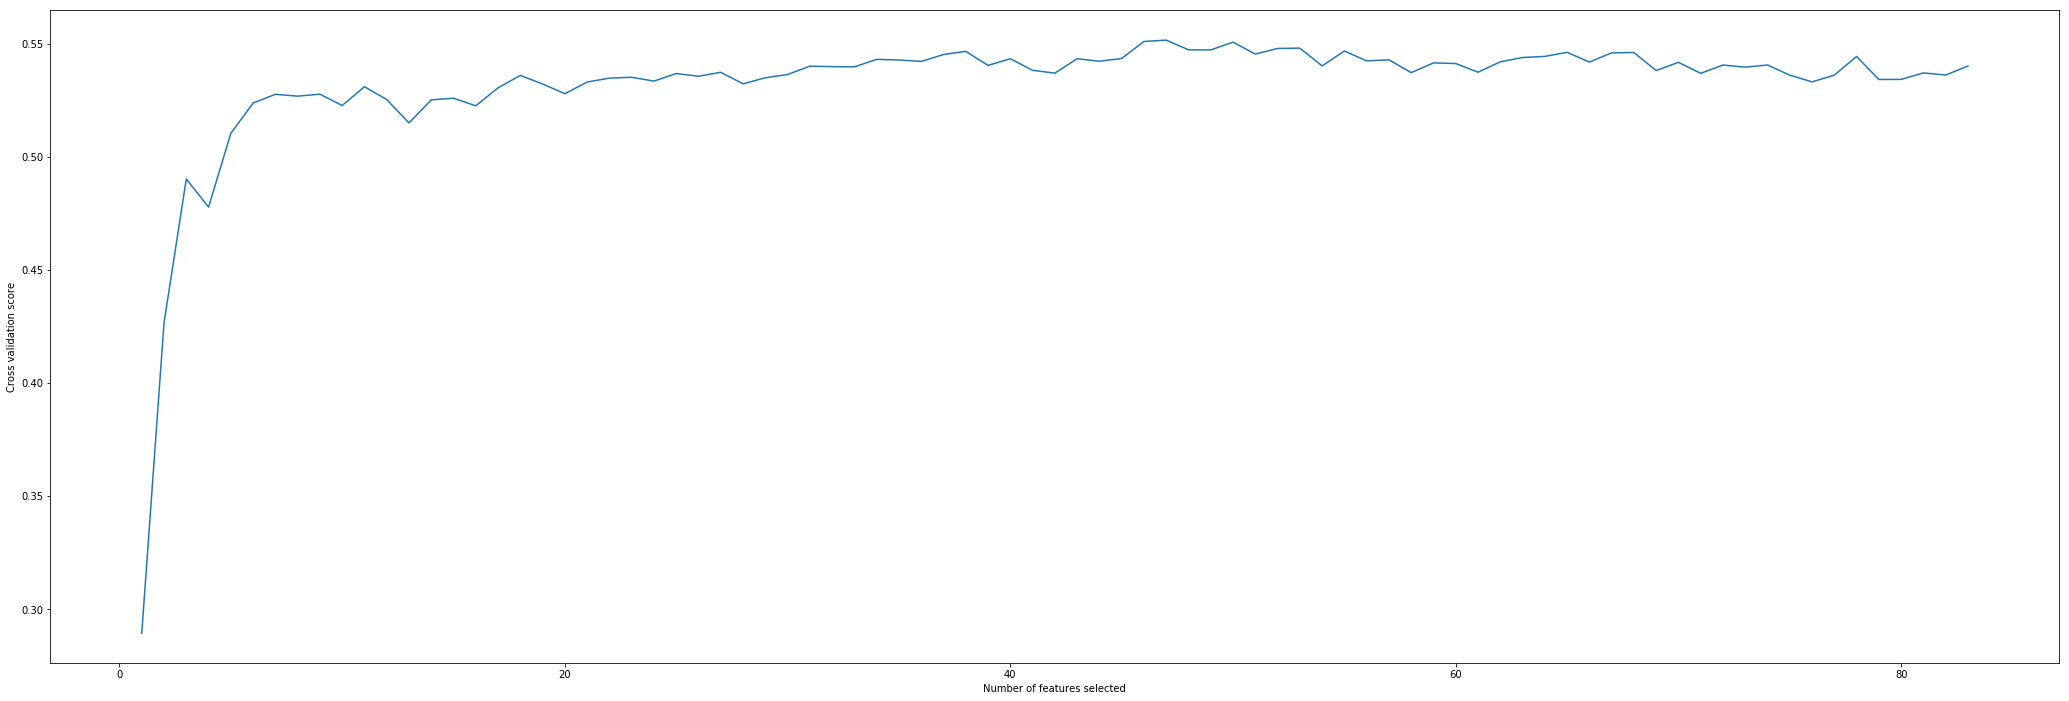

In [153]:
# Plot the results of the recursive feature eliminator
plot.figure()
plot.xlabel("Number of features selected")
plot.ylabel("Cross validation score")
plot.plot(range(1, len(recursive_eliminator_regressor.grid_scores_) + 1), recursive_eliminator_regressor.grid_scores_)
plot.show()

In [154]:
# Select the optimal subset of features for the regressor
regressor_features = pd.DataFrame({'predictor': list(X.columns),
                                   'select': recursive_eliminator_regressor.ranking_.tolist()})
regressor_features = regressor_features.loc[regressor_features['select'] == 1]
regressor_features = regressor_features['predictor'].tolist()
regressor_features

['compoundTopographic',
 'streamLargeDist',
 'streamSmallDist',
 'surfaceRelief',
 'aspect',
 'may_1_ultraBlue',
 'may_4_red',
 'may_7_shortInfrared2',
 'may_evi2',
 'may_nbr',
 'may_ndsi',
 'may_ndvi',
 'june_1_ultraBlue',
 'june_4_red',
 'june_5_nearInfrared',
 'june_7_shortInfrared2',
 'june_evi2',
 'june_nbr',
 'june_ndmi',
 'june_ndsi',
 'june_ndvi',
 'june_ndwi',
 'july_1_ultraBlue',
 'july_2_blue',
 'july_3_green',
 'july_4_red',
 'july_5_nearInfrared',
 'july_6_shortInfrared1',
 'july_7_shortInfrared2',
 'july_evi2',
 'july_nbr',
 'july_ndmi',
 'july_ndsi',
 'july_ndvi',
 'july_ndwi',
 'august_1_ultraBlue',
 'august_3_green',
 'august_evi2',
 'august_ndmi',
 'august_ndvi',
 'august_ndwi',
 'september_1_ultraBlue',
 'september_3_green',
 'september_7_shortInfrared2',
 'september_nbr',
 'september_ndsi',
 'september_ndvi']

### 5.2. Bayesian Optimization

The Gradient Boosting Classifier was optimized using all available data, and the performance was evaluated as area under the receiver operating characteristic curve (AUC). For comparison, the performance of a Random Forest Classifier was also tested using 5-fold cross validation.

The Gradient Boosting Regressor was optimized using presence data only, and the performance was evaluated as negative mean squared error (-MSE). For ease of interpretation, we report root mean squared error (RMSE) rather than -MSE. For comparison, the performance of a Random Forest Regressor was also tested using 5-fold cross validation.

### 5.3. Train and Test Iterations (n=100)

In [163]:
# Create empty lists to store threshold and performance metrics
threshold_list = []
sensitivity_list = []
specificity_list = []
auc_list = []
accuracy_list = []
r_score_list = []
mae_list = []
rmse_list = []
# Create an empty data frame to store the test results
output_test = pd.DataFrame(columns=output_variables)
i = 1
while i < 101:
    # Set output display to show one message with replacement
    clear_output(wait=True)
    # Split the data into train and test partitions
    all_train, all_test = partitionData(input_data, all_variables, predictor_all, zero_variable, strata)
    # Train and predict a classifier
    all_test, classifier = trainPredictClassifier(all_train, all_test, classifier_features, zero_variable)
    # Subset the training data to quantitative presences
    presence_train = all_train[all_train[cover[0]] >= 1]
    presence_train = presence_train[presence_train['methodCover'] == 'Quantitative']
    presence_train = presence_train[presence_train['project'] == 'AIM NPR-A']
    # Train and predict a regressor
    all_test, regressor = trainPredictRegressor(presence_train, all_test, regressor_features, cover)
    # Calculate the optimal threshold and performance of the presence-absence classification
    threshold, sensitivity, specificity, auc, accuracy = determineOptimalThreshold(all_test[presence[0]], all_test[zero_variable[0]])
    # Composite the classifier and regressor predictions
    all_test = compositePrediction(all_test, presence, response, threshold)
    # Subset the test data to quantitative
    quantitative_test = all_test[all_test['methodCover'] == 'Quantitative']
    quantitative_test = quantitative_test[quantitative_test['project'] == 'AIM NPR-A']
    # Calculate overall performance
    r_score, mae, rmse = calculatePerformance(quantitative_test, cover, prediction)
    # Add threshold and performance metrics to list
    threshold_list.append(threshold)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    auc_list.append(auc)
    accuracy_list.append(accuracy)
    r_score_list.append(r_score)
    mae_list.append(mae)
    rmse_list.append(rmse)
    # Add the test results to output data frame
    output_test = output_test.append(all_test, ignore_index=True, sort=True)
    print('Model train-test iteration ' + str(i) + ' out of 100 completed...')
    # Increase the counter by 1
    i = i+1

Model train-test iteration 100 out of 100 completed...


### 5.4. Export Results

In [164]:
# Export test results to csv
output_test.to_csv(output_csv, header=True, index=False, sep=',', encoding='utf-8')

In [165]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

In [166]:
# Export a Pearson Correlation plot for the predictor variables
plotVariableCorrelation(input_data[predictor_metrics], variable_correlation)

In [167]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 36
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

In [168]:
# Train and export a final classifier using the full input data
trainExportClassifier(input_data,
                      classifier_features,
                      zero_variable,
                      output_classifier,
                      importance_classifier)

In [169]:
# Subset the input data to presences only
presence_data = input_data[input_data[cover[0]] >= 1]
presence_data = presence_data[presence_data['methodCover'] == 'Quantitative']
presence_data = presence_data[presence_data['project'] == 'AIM NPR-A']
# Train and export a final regressor using the full input data
trainExportRegressor(presence_data,
                     regressor_features,
                     cover,
                     output_regressor,
                     importance_regressor)

In [170]:
# Calculate mean for threshold and all performance metrics
threshold_mean = np.mean(threshold_list)
sensitivity_mean = np.mean(sensitivity_list)
specificity_mean = np.mean(specificity_list)
auc_mean = np.mean(auc_list)
accuracy_mean = np.mean(accuracy_list)
r_score_mean = np.mean(r_score_list)
mae_mean = np.mean(mae_list)
rmse_mean = np.mean(rmse_list)
# Calculate standard deviation for threshold and all performance metrics
threshold_sd = np.std(threshold_list)
sensitivity_sd = np.std(sensitivity_list)
specificity_sd = np.std(specificity_list)
auc_sd = np.std(auc_list)
accuracy_sd = np.std(accuracy_list)
r_score_sd = np.std(r_score_list)
mae_sd = np.std(mae_list)
rmse_sd = np.std(rmse_list)

In [171]:
# Export threshold and performance metrics as a table
metrics_dataframe = pd.DataFrame({'threshold':threshold_list,
                                  'sensitivity':sensitivity_list,
                                  'specificity':specificity_list,
                                  'auc':auc_list,
                                  'accuracy':accuracy_list,
                                  'r_score':r_score_list,
                                  'mae':mae_list,
                                  'rmse':rmse_list})
metrics_dataframe.to_csv(metrics_file, header=True, index=False, sep=',', encoding='utf-8')

In [172]:
# Write a text file to store the presence-absence conversion threshold
file = open(threshold_file, 'w')
file.write(str(round(threshold_mean, 5)))
file.close()

In [173]:
# Write html text file
output_report = os.path.join(output_folder, output_report_name)
output_text = os.path.splitext(output_report)[0] + ".txt"
text_file = open(output_text, "w")
text_file.write("<html>\n")
text_file.write("<head>\n")
text_file.write("<meta http-equiv=\"pragma\" content=\"no-cache\">\n")
text_file.write("<meta http-equiv=\"Expires\" content=\"-1\">\n")
text_file.write("</head>\n")
text_file.write("<body>\n")
text_file.write("<div style=\"width:90%;max-width:1000px;margin-left:auto;margin-right:auto\">\n")
text_file.write("<h1 style=\"text-align:center;\">Distribution-abundance model performance for " + taxon_name + "</h1>\n")
text_file.write("<br>" + "\n")
text_file.write("<h2>Predicted Distribution-abundance Pattern</h2>\n")
text_file.write("<p>Distribution-abundance was predicted by a composite hierarchical model: 1. a classifier predicted species presence or absence, and 2. a regressor predicted species proportional abundance in areas where the classifier predicted the species is present. The map below shows the output raster prediction.</p>\n")
text_file.write("<p><i>Prediction step has not yet been performed. No output to display.</i></p>\n")
text_file.write("<h2>Composite Model Performance</h2>\n")
text_file.write("<p>Model performance was measured by pseudo r squared, mean absolute error, and root mean squared error for the composite prediction. Additionally, the performance of the absence class is reported as an area under the receiver operating characteristic curve (AUC) and overall accuracy, where specificity and sensitivity are as close to equal as possible (i.e, the model performs equally well at predicting absences and presences). All performance results are reported as the mean and standard deviation of the independent test predictions from 100 train-test splits. For each split, 30% of the data was withheld from model training and used as an independent test partition. The test partition was randomly selected from cover class strata: 0%, 1-10%, 11-25%, and 26-100%.</p>\n")
text_file.write("<h3>Overall Performance</h3>\n")
text_file.write("<p>Pseudo r-squared = " + str(np.round(r_score_mean, 2)) + " +/- " + str(np.round(r_score_sd, 2)) +"</p>\n")
text_file.write("<p>Mean Absolute Error = " + str(np.round(mae_mean, 2)) + " +/- " + str(np.round(mae_sd, 2)) +"</p>\n")
text_file.write("<p>Root Mean Squared Error = " + str(np.round(rmse_mean, 2)) + " +/- " + str(np.round(rmse_sd, 2)) +"</p>\n")
text_file.write("<h3>Absence Performance</h3>\n")
text_file.write("<p>AUC = " + str(np.round(auc_mean, 2)) + " +/- " + str(np.round(auc_sd, 2)) +"</p>\n")
text_file.write("<p>Presence-Absence Accuracy = " + str(np.round(accuracy_mean, 2)) + " +/- " + str(np.round(accuracy_sd, 2)) +"</p>\n")
text_file.write("<h3>Classifier Importances</h3>\n")
text_file.write("<p>The Variable Importance plot for the classifier is shown below:</p>\n")
text_file.write("<a target='_blank' href='plots\\importance_classifier.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_classifier.png'></a>\n")
text_file.write("<h3>Regressor Importances</h3>\n")
text_file.write("<p>The Variable Importance plot for the regressor is shown below:</p>\n")
text_file.write("<a target='_blank' href='plots\\importance_regressor.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_regressor.png'></a>\n")
text_file.write(r"<h2>Variable Correlation</h2>" + "\n")
text_file.write("<p>The plot below explores variable correlation. No attempt was made to remove highly correlated variables (shown in the plot dark blue).</p>\n")
text_file.write("<a target='_blank' href='plots\\variable_correlation.png'><img style='display:inline-block;width:100%;' src='plots\\variable_correlation.png'></a>\n")
text_file.write("</div>\n")
text_file.write("</body>\n")
text_file.write("</html>\n")
text_file.close()

In [174]:
# Rename HTML Text to HTML
if os.path.exists(output_report) == True:
    os.remove(output_report)
os.rename(output_text, output_report)